In [1]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


start_date = datetime(2023, 8, 28, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 6, 23, 59, 59).replace(tzinfo=timezone.utc)

sensor_id = 1

acropolis_path = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"
picarro_path = r"/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/PICARRO"

#Calibration
picarro_slope = 1.0061589132696314
picarro_intercept = 0.14607153970888476

acropolis_slope = 1.0250943998298148
acropolis_intercept = -24.071573685050566

In [2]:
df = pl.scan_parquet(os.path.join(acropolis_path, "old_db_renamed_measurements.parquet"))

df_a = df.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_a = df_a.with_columns((pl.col("gmp343_compensated") * acropolis_slope + acropolis_intercept).alias("gmp343_compensated_corr"))

df_a.tail(3).collect()

integer,creation_timestamp,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,gas_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,gmp343_compensated_corr
i64,"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
8999875,2023-09-06 23:59:36.240 UTC,"""tum-esm-midcos…","""measurement""",415.4,466.0,466.0,35.41,32.33,945.17,29.42,29.44,30.6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,453.622417
8999898,2023-09-06 23:59:46.250 UTC,"""tum-esm-midcos…","""measurement""",407.7,455.1,455.1,35.44,32.28,941.57,29.4,29.43,30.6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,442.448888
8999917,2023-09-06 23:59:56.250 UTC,"""tum-esm-midcos…","""measurement""",409.6,459.5,459.5,35.37,32.29,943.16,29.41,29.44,30.6,null,null,null,null,null,null,null,null,null,null,null,null,null,null,446.959303


In [3]:
df = pl.scan_parquet(os.path.join(picarro_path, "picarro.parquet"))
df = df.with_columns(pl.col("datetime").dt.cast_time_unit("us").dt.replace_time_zone("UTC").alias("creation_timestamp"))

df_p = df.sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_p = df_p.with_columns((pl.col("CO2_dry") * picarro_slope + picarro_intercept).alias("CO2_corr"))

df_p.tail(3).collect()

DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,creation_timestamp,CO2_corr
str,str,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],i64,"datetime[μs, UTC]",f64
"""2023-09-06""","""23:59:53.891""",248.999929,5975.998303,249.999929,1.6940e9,0,963,139.966293,44.99987,42.375,45.159081,3.0,22544.8125,2.241052,2.28512,438.017981,448.548933,1.876141,1181.387572,81.470623,1084.689138,56.953321,-0.074807,-0.044914,2023-09-06 23:59:53.891,4082727,2023-09-06 23:59:53.891 UTC,451.457578
"""2023-09-06""","""23:59:56.839""",248.999963,5975.999122,249.999963,1.6940e9,0,963,139.985672,44.99987,42.375,45.159081,3.0,22548.044922,2.240867,2.284914,438.078484,448.606578,1.87822,1181.351933,76.9199,1084.743788,60.039974,-0.074787,-0.044904,2023-09-06 23:59:56.839,4082728,2023-09-06 23:59:56.839 UTC,451.515578
"""2023-09-06""","""23:59:58.394""",248.999981,5975.999554,249.999981,1.6940e9,0,963,140.034836,44.99987,42.375,45.159081,2.0,22562.769531,2.240825,2.284914,438.078484,448.606578,1.87822,1181.463578,76.9199,1084.821851,60.039974,-0.074777,-0.044894,2023-09-06 23:59:58.394,4082729,2023-09-06 23:59:58.394 UTC,451.515578


In [4]:
filter = '1h'

df_a = df_a.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

df_p = df_p.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

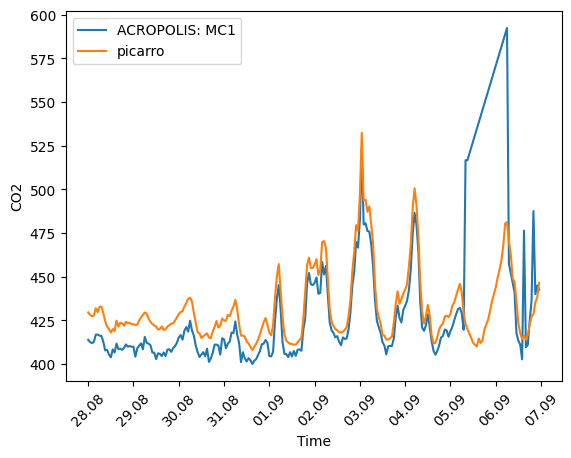

In [5]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="gmp343_compensated_corr", label = f"ACROPOLIS: MC{sensor_id}")
sns.lineplot(data=df_p.collect(), x="creation_timestamp", y="CO2_corr", label = "picarro")

# set axes labels
plt.xlabel("Time")
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# show the plot
plt.show()

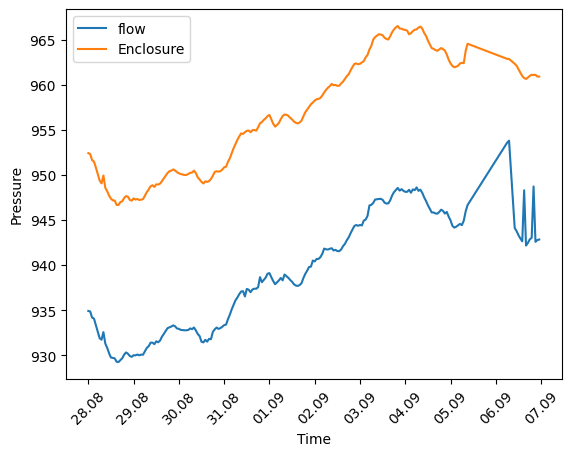

In [6]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="bme280_pressure", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_pressure", label = f"Enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Pressure')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

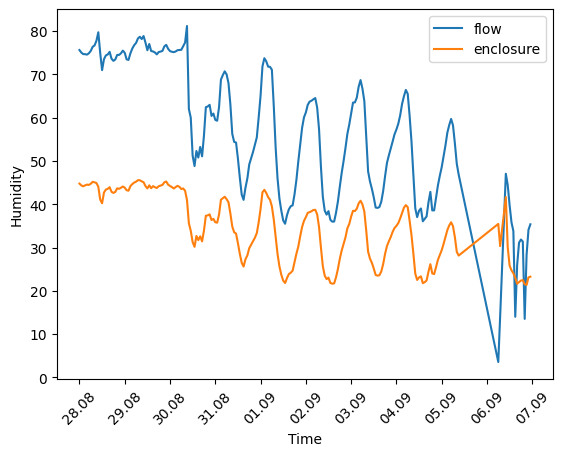

In [7]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_humidity", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_humidity", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Humidity')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

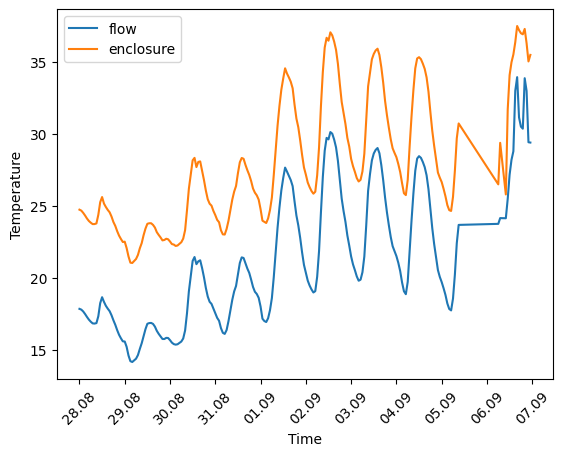

In [8]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_temperature", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_temperature", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

In [9]:
df = df_a.join(df_p, left_on= "creation_timestamp", right_on= "creation_timestamp")
df.tail(3).collect()

creation_timestamp,integer,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,gas_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,gmp343_compensated_corr,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,CO2_corr
"datetime[μs, UTC]",f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
2023-09-06 21:00:00 UTC,8.9838e6,null,null,403.227451,452.759944,452.759944,28.325042,24.761597,942.585994,32.997255,32.987563,30.793557,null,1.55,1.757143,1.342857,53.785714,59.142857,48.178571,1.6940e9,0.033679,0.44,55.585714,21.375,961.104286,36.314286,440.050109,null,null,248.895779,5973.498704,249.895779,1.6940e9,0.0,963.0,140.000725,44.999968,42.714672,45.154032,2.020833,22551.323888,2.138597,2.177869,423.007393,432.503755,1.760841,1181.395489,84.005729,1084.756004,61.967981,-0.074687,-0.044879,null,4077779.5,435.31358
2023-09-06 22:00:00 UTC,8.9885e6,null,null,409.63,457.595385,457.595385,34.107077,31.0,942.783077,29.423077,29.429538,29.844615,null,2.044444,2.133333,1.922222,43.444444,45.444444,41.333333,1.6940e9,0.034789,0.44,54.473684,23.126316,960.920526,35.044211,445.006892,null,null,248.937436,5974.49846,249.937436,1.6940e9,0.0,963.0,140.000646,44.999964,42.555425,45.154252,2.036772,22544.255335,2.172531,2.213355,425.528243,435.310619,1.800565,1181.413144,81.866193,1084.763688,60.693381,-0.0749,-0.044978,null,4079766.5,438.137731
2023-09-06 23:00:00 UTC,8.9991e6,null,null,406.10678,455.135593,455.135593,35.382034,32.292373,942.843729,29.401525,29.421356,30.567797,null,1.95,1.95,1.85,38.0,40.0,35.0,1.6940e9,0.034727,0.44,54.863636,23.274545,960.915455,35.5,442.485374,null,null,248.978823,5975.491753,249.978823,1.6940e9,0.0,963.0,140.000038,44.999969,42.422261,45.154224,2.035282,22536.832278,2.229988,2.273457,433.356555,443.684252,1.862925,1181.444423,82.110543,1084.780404,60.769309,-0.074901,-0.044941,null,4081737.5,446.562936


<Axes: xlabel='gmp343_compensated_corr', ylabel='CO2_corr'>

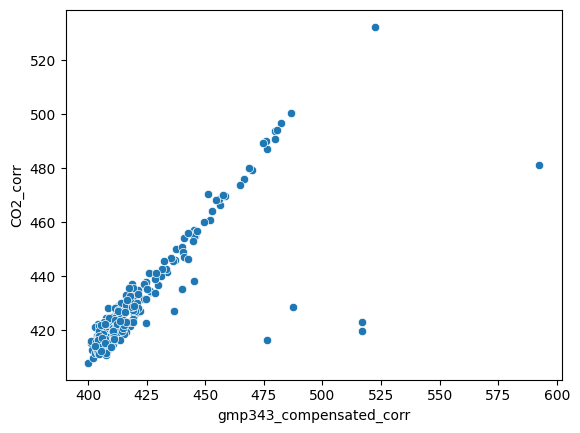

In [10]:
sns.scatterplot(data = df.collect(), x= "gmp343_compensated_corr", y = "CO2_corr" )